In [ ]:
# For plotting
import matplotlib
matplotlib.use("Agg")

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import argparse
from IPython.display import Image


In [ ]:
print("Loading images...")
imagePaths = list(paths.list_images('/content/drive/MyDrive/Root Monitoring of Hydroponic Crop Plants/dataset'))

Loading images...


In [ ]:
data = []
labels = []

for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, convert it to grayscale, and resize it to be a
    # fixed 64x64 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [ ]:
data = np.array(data, dtype="float") / 255.0
# Reshaping for channel dimension
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 1))

In [ ]:
# Encoding Labels
LE = LabelEncoder()
labels = LE.fit_transform(labels)

In [ ]:
from tensorflow.keras.utils import to_categorical
# One-hot Encoding
labels = to_categorical(labels, num_classes=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
print("Compiling model...")

epochs = int(input("Enter the no. of epochs: "))

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

learning_rate = 1e-4
decay_steps = 10000  # You can adjust this value as needed
decay_rate = 0.9  # You can adjust this value as needed

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
)

optimizer = Adam(learning_rate=learning_rate_schedule)

# Model
def convNet(width, height, depth, classes, reg):

    # initialize the model along with the input shape to be
    # "channels last"
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(64, (11, 11), input_shape=inputShape, padding="same", kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(128, (5, 5), padding="same", kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # third (and final) CONV => RELU => POOL layers
    model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first and only set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=reg))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

Compiling model...
Enter the no. of epochs: 500


In [ ]:
from tensorflow.keras.layers import Activation


In [ ]:
model = convNet(width=64, height=64, depth=1, classes=len(LE.classes_), reg=l2(0.0002))
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
print("Training network for {} epochs...".format(epochs))
ConvNet = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=epochs, verbose=1)
print("Training Completed!")

Training network for 500 epochs...
Epoch 1/500
29/29 [==============================] - 3s 34ms/step - loss: 0.9411 - accuracy: 0.4837 - val_loss: 0.9224 - val_accuracy: 0.5298
Epoch 2/500
29/29 [==============================] - 1s 25ms/step - loss: 0.9129 - accuracy: 0.5218 - val_loss: 0.9025 - val_accuracy: 0.4702
Epoch 3/500
29/29 [==============================] - 1s 25ms/step - loss: 0.8942 - accuracy: 0.5381 - val_loss: 0.8830 - val_accuracy: 0.8278
Epoch 4/500
29/29 [==============================] - 1s 23ms/step - loss: 0.8747 - accuracy: 0.5741 - val_loss: 0.8637 - val_accuracy: 0.8168
Epoch 5/500
29/29 [==============================] - 1s 25ms/step - loss: 0.8537 - accuracy: 0.6296 - val_loss: 0.8343 - val_accuracy: 0.8896
Epoch 6/500
29/29 [==============================] - 1s 22ms/step - loss: 0.7887 - accuracy: 0.6928 - val_loss: 0.7478 - val_accuracy: 0.4746
Epoch 7/500
29/29 [==============================] - 1s 26ms/step - loss: 0.7573 - accuracy: 0.6885 - val_loss: 0

In [ ]:
print("Evaluating the network")
predictions = model.predict(X_test, batch_size=32)

Evaluating the network
5/5 [==============================] - 0s 7ms/step


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[60, 15],
       [ 0, 78]])

In [ ]:
#from sklearn.metrics import accuracy_score

#print("Evaluating the network")
predictions = model.predict(X_test, batch_size=32)

# Calculate accuracy
#accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Print accuracy
#print("Accuracy:", accuracy)


Evaluating the network
5/5 [==============================] - 0s 7ms/step
Accuracy: 0.9019607843137255


In [ ]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=LE.classes_))

                precision    recall  f1-score   support

    hairy_root       1.00      0.80      0.89        75
non_hairy_root       0.84      1.00      0.91        78

      accuracy                           0.90       153
     macro avg       0.92      0.90      0.90       153
  weighted avg       0.92      0.90      0.90       153



KeyError: ignored

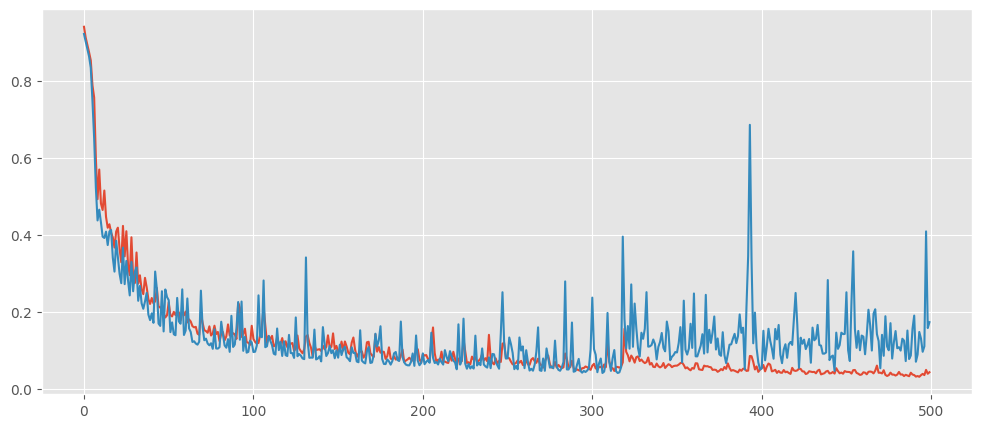

In [ ]:
# Plot the training loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(np.arange(0, epochs), ConvNet.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), ConvNet.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), ConvNet.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), ConvNet.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

Text(0.5, 1.0, 'Training Loss and Accuracy on Dataset')

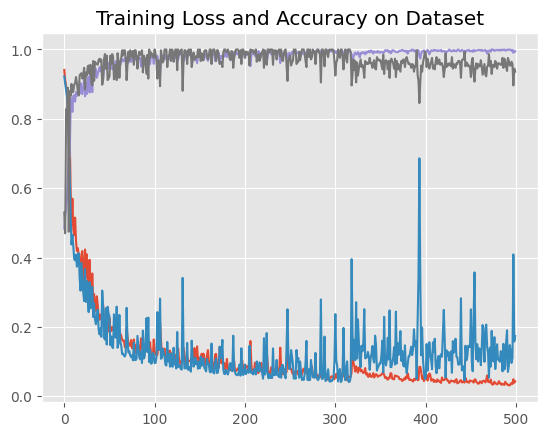

In [ ]:
plt.plot(np.arange(0, epochs), ConvNet.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), ConvNet.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), ConvNet.history["accuracy"], label="train_acc")  # Use "accuracy" instead of "acc"
plt.plot(np.arange(0, epochs), ConvNet.history["val_accuracy"], label="val_acc")  # Use "val_accuracy" instead of "val_acc"
plt.title("Training Loss and Accuracy on Dataset")


In [ ]:
# Randomly select test images
testImages = np.arange(0, y_test.shape[0])
testImages = np.random.choice(testImages, size=(25,), replace=False)
images = []

In [ ]:
for ti in testImages:
    # Grab the current testing image and classify it

    image = np.expand_dims(X_test[ti], axis=0)
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = LE.classes_[j]

    # Rescale the image into the range [0, 255] and then resize it so
    # We can more easily visualize it
    output = (image[0] * 255).astype("uint8")
    output = np.dstack([output] * 3)
    output = cv2.resize(output, (128, 128))

    # Draw the class label on the output image and add it to the set of output images
    if label == 'non_hairy_root':
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    images.append(output)

1/1 [==============================] - 0s 32ms/step


In [ ]:
# Create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

In [ ]:
#from google.colab.patches import cv2_imshow
#while True:
#    cv2_imshow(montage)  # Use cv2_imshow instead of cv2.imshow
#    if cv2.waitKey(1) == 13:  # 13 is the Enter Key
#        break

#run this cell for the image classification output 

In [ ]:
# Image(filename="Images/output.png")

In [ ]:
# Save the model to an HDF5 file
model.save("Hydroponic_Root_CNN.h5")
